In [1]:
import os
import datetime
from dateutil.relativedelta import relativedelta
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

# get data

This free project will be using free data from QuantQuote. This dataset contains daily pricing data for all S&P 500 members as of August 2013, which is where the dataset ends. For each member, the data begins when that stock entered the index.

In [3]:
def get_data(data_url):
    with requests.get(data_url) as r:

        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall()

In [4]:
data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

In [5]:
get_data(data_url=data_url)

In [6]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [7]:
len(os.listdir(data_dir))

500

In [8]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [9]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

In [10]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [11]:
aapl_df = get_df("table_aapl.csv")

In [12]:
aapl_df.head()

,date,open,high,low_price,close,volume
date,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95


# 1. Exploratory Analysis

Transform our data - smoothing, rescaling, and aggregating.

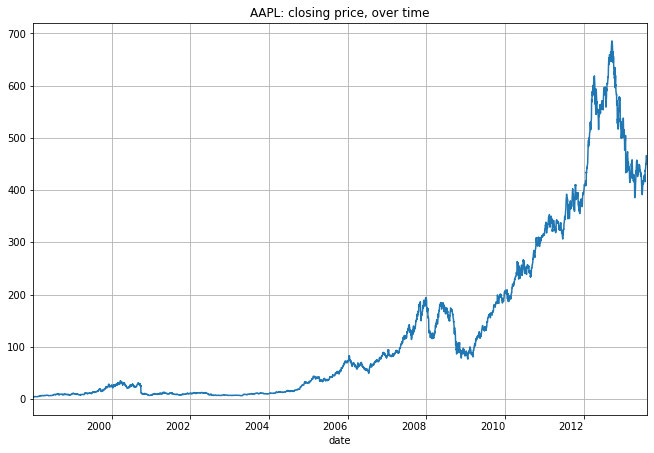

In [13]:
ax = aapl_df.close.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: closing price, over time")

# Prices -> Returns

In [14]:
aapl_df["return_daily"] = aapl_df.close.pct_change()

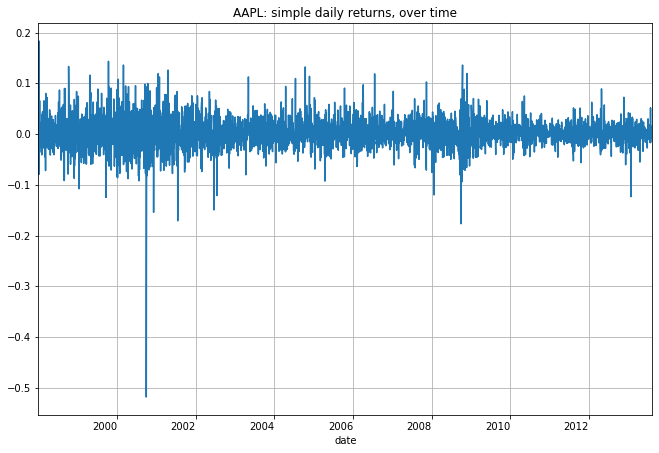

In [15]:
ax = aapl_df.return_daily.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: simple daily returns, over time")

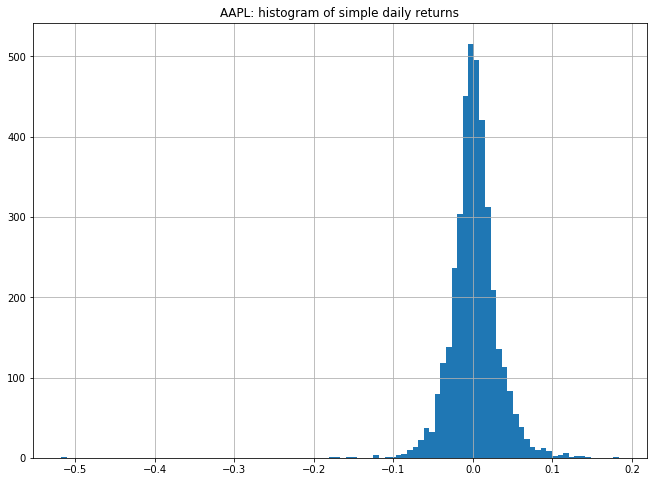

In [16]:
ax = aapl_df.return_daily.hist(bins=100, figsize=(11, 8))
g = ax.grid(True)
t = ax.title.set_text("AAPL: histogram of simple daily returns")

# Autocorrelation

In [17]:
aapl_df.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        aapl_df.return_daily.shift(1).rename("t-1")
                   ).corr()

,t,t-1
t,1.000000,-0.034992
t-1,-0.034992,1.000000


In [18]:
aapl_df.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        aapl_df.return_daily.shift(1).rename("t-1")
                   ).corr().iloc[0, 1]

-0.034991926552352906

In [19]:
# get autocorrelation going back through 30 lags and plot the results
auto_corrs = {}

for i in range(1, 31):
    auto_corrs[i] = aapl_df.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        aapl_df.return_daily.shift(i).rename(f"t-{i}")
                   ).corr().iloc[1, 0]

In [20]:
auto_corrs = pd.Series(auto_corrs)

In [21]:
auto_corrs = auto_corrs.to_frame()

In [22]:
auto_corrs.index.name = "lag"

In [23]:
auto_corrs.columns = ["auto_corr"]

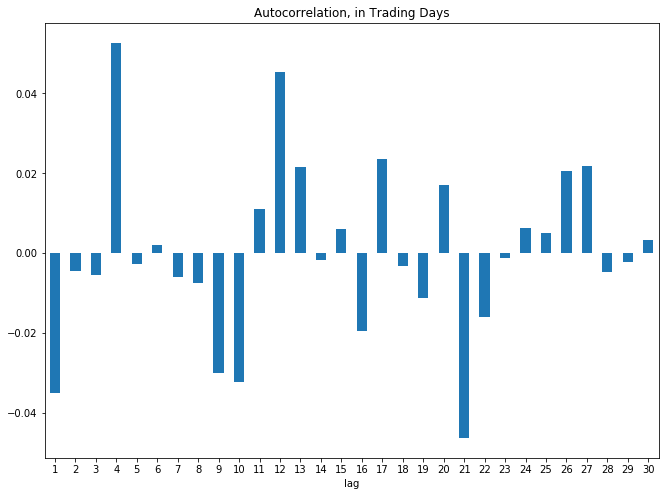

In [24]:
ax = auto_corrs.plot.bar(figsize=(11, 8), rot=0)
t = ax.title.set_text("Autocorrelation, in Trading Days")
ax.legend().remove()

# Monthly returns

In [25]:
aapl_df["year"] = aapl_df.date.dt.year
aapl_df["month"] = aapl_df.date.dt.month
aapl_df["return_daily_gross"] = aapl_df.return_daily + 1

In [26]:
aapl_df.head()

,date,open,high,low_price,close,volume,return_daily,year,month,return_daily_gross
date,,,,,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10,NaN,1998,1,NaN
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08,-0.015384,1998,1,0.984616
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55,0.183749,1998,1,1.183749
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52,-0.079196,1998,1,0.920804
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95,0.035552,1998,1,1.035552


In [27]:
aapl_monthly = aapl_df.groupby(["year", "month"]).return_daily_gross.prod()

In [28]:
aapl_monthly.shape

(188,)

In [29]:
aapl_monthly = aapl_monthly.rename("return_t")

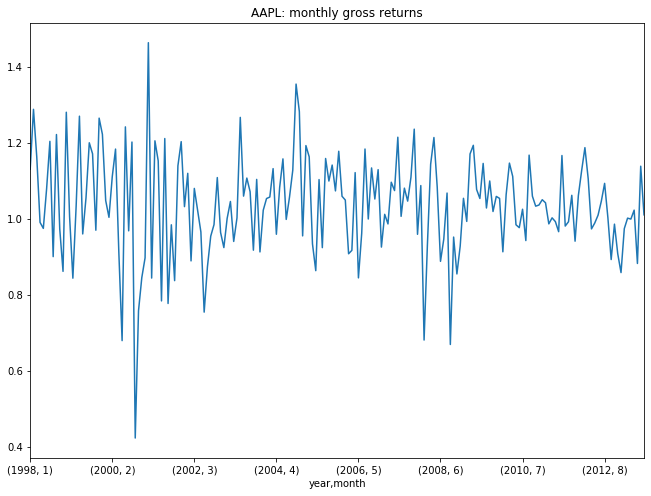

In [30]:
ax = aapl_monthly.plot(figsize=(11, 8))
t = ax.set_title("AAPL: monthly gross returns")

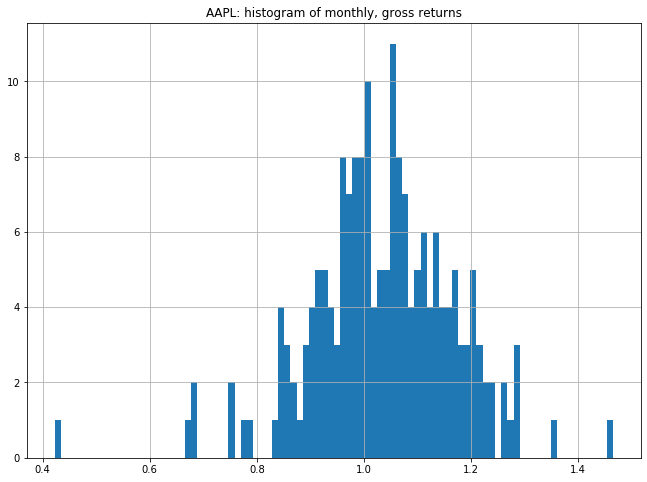

In [31]:
ax = aapl_monthly.hist(bins=90, figsize=(11, 8))
t = ax.title.set_text("AAPL: histogram of monthly, gross returns")

In [32]:
aapl_monthly = aapl_monthly.to_frame()

# Rolling

create a rolling window of variable lengths over our data, and apply different sorts of aggregations

## Cumulative

look at returns over the last 21 or so days (there are typically about 21 trading days in a month).

In [33]:
aapl_df["return_cumulative_21_day"] = aapl_df.return_daily_gross.dropna().rolling(21).apply(np.prod, raw=True) - 1

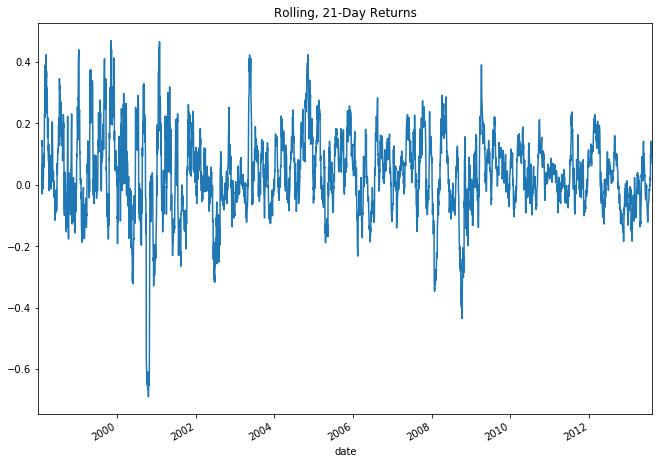

In [34]:
ax = aapl_df.return_cumulative_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Returns")

## Average

look at average daily return over a rolling period, which can help represent daily movements in a smoother sort of way than looking at the actual daily values.

In [35]:
aapl_df["return_mean_21_day"] = aapl_df.return_daily.rolling(21).mean()

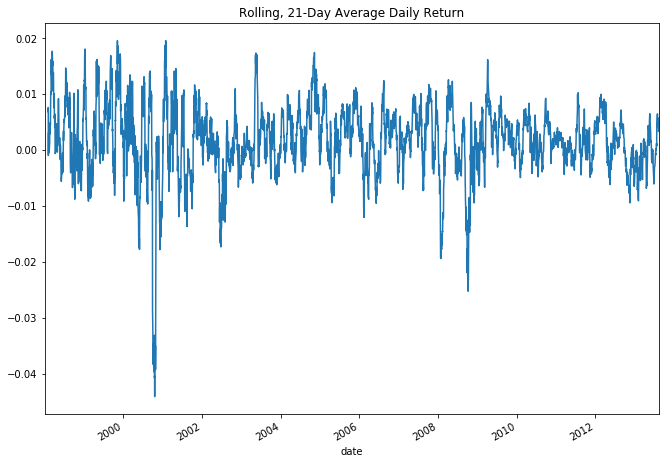

In [36]:
ax = aapl_df.return_mean_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Average Daily Return")

## Volatility

In [37]:
aapl_df["return_std_21_day"] = aapl_df.return_daily.rolling(21).std()

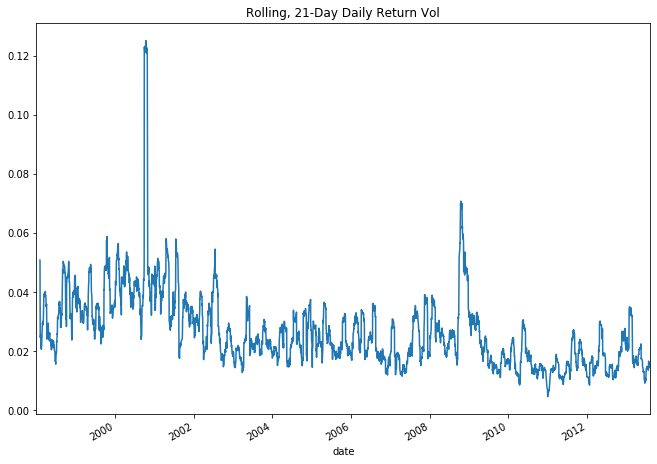

In [38]:
ax = aapl_df.return_std_21_day.plot(figsize=(11, 8))
t = ax.title.set_text("Rolling, 21-Day Daily Return Vol")


## Comparisons

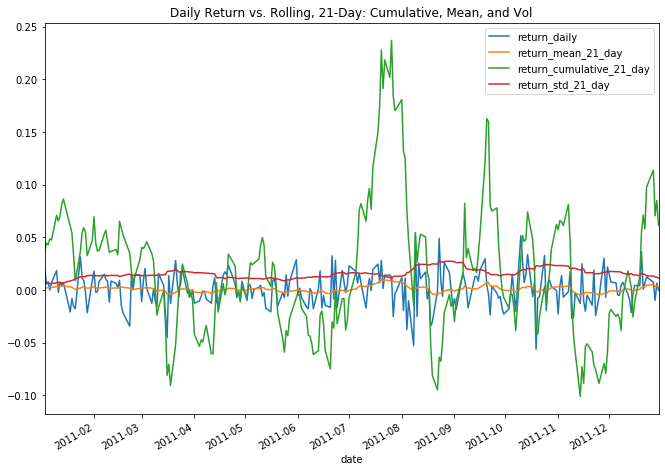

In [39]:
ax = aapl_df.loc[
    aapl_df.year == 2011,
    ["return_daily", "return_mean_21_day", "return_cumulative_21_day", "return_std_21_day"]
            ].plot(figsize=(11, 8))

t = ax.title.set_text("Daily Return vs. Rolling, 21-Day: Cumulative, Mean, and Vol")

In [40]:
# comparisons of rolling Sharpe ratios
def rolling_sharpe(window, rf=.03):
    ret = aapl_df.return_daily_gross.rolling(window).apply(np.prod, raw=True) - 1
    vol = aapl_df.return_daily.rolling(window).std()
    return (ret - rf) / vol

In [41]:
rolling_sharpe(5).dropna().head()

date
1998-01-09    0.955102
1998-01-12    1.243380
1998-01-13    0.079812
1998-01-14    3.808467
1998-01-15    0.985570
dtype: float64

In [42]:
sharpes = pd.concat([rolling_sharpe(5), rolling_sharpe(20), rolling_sharpe(60)], axis=1)

In [43]:
sharpes.columns = ["rolling_5", "rolling_20", "rolling_60"]

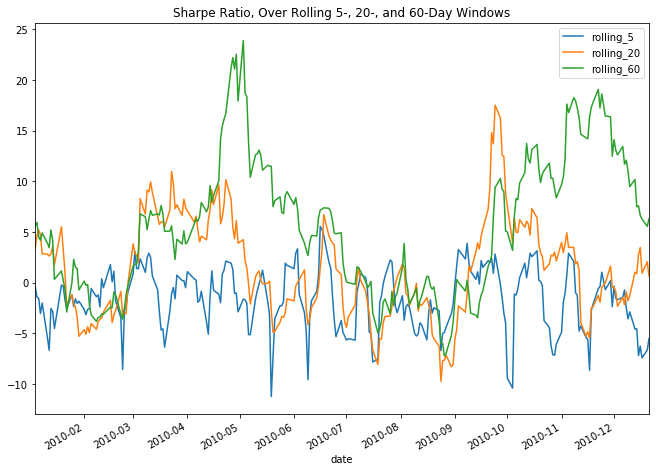

In [44]:
ax = sharpes.loc[datetime.date(2010, 1, 1):datetime.date(2010, 12, 21)].plot(figsize=(11, 8))
t = ax.title.set_text("Sharpe Ratio, Over Rolling 5-, 20-, and 60-Day Windows")

# Dummy Variables

need to be one-hot encoded - a vector of categorical data becomes a matrix with one bool column for each categorical value.

## Day of the week

In [45]:
aapl_df["day_of_week"] = aapl_df.date.dt.dayofweek

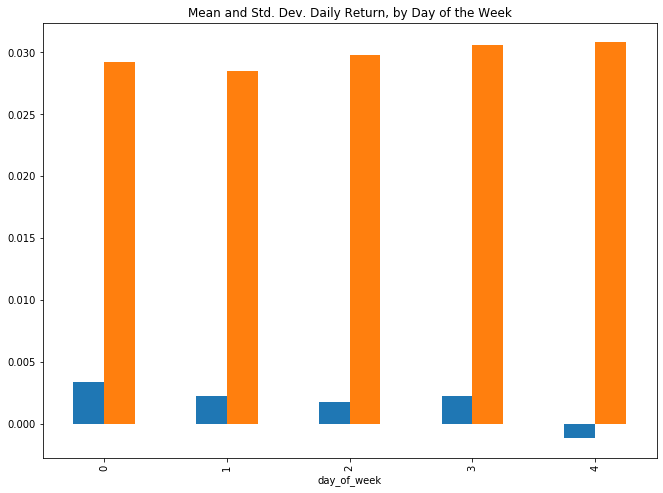

In [46]:
ax = aapl_df[
        ["return_daily", "day_of_week"]
            ].groupby(
        "day_of_week"
            ).agg(
        [np.mean, np.std]
            ).plot.bar(
        figsize=(11, 8))

ax.legend().remove()

t = ax.title.set_text("Mean and Std. Dev. Daily Return, by Day of the Week")

In [47]:
d_o_w = pd.get_dummies(aapl_df.day_of_week, drop_first=True)

In [48]:
d_o_w.head()

,1,2,3,4
date,,,,
1998-01-02,0,0,0,1
1998-01-05,0,0,0,0
1998-01-06,1,0,0,0
1998-01-07,0,1,0,0
1998-01-08,0,0,1,0


In [49]:
d_o_w.columns = [f"day_of_week_{c}" for c in d_o_w.columns]

In [50]:
d_o_w = d_o_w.join(aapl_df.return_daily)

In [51]:
# split dataset to training and testing part
train = d_o_w.loc[datetime.date(2012, 1, 1):datetime.date(2012, 11, 30)]
test = d_o_w.loc[datetime.date(2012, 12, 1):datetime.date(2012, 12, 31)]

In [52]:
train.shape

(230, 5)

In [53]:
test.shape

(20, 5)

In [54]:
reg = LinearRegression()

In [55]:
train.iloc[:, :4].head()

,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4
date,,,,
2012-01-03,1,0,0,0
2012-01-04,0,1,0,0
2012-01-05,0,0,1,0
2012-01-06,0,0,0,1
2012-01-09,0,0,0,0


In [56]:
train.return_daily.head()

date
2012-01-03    0.014447
2012-01-04    0.006595
2012-01-05    0.011296
2012-01-06    0.009899
2012-01-09   -0.001658
Name: return_daily, dtype: float64

In [57]:
reg = reg.fit(train.iloc[:, :4], train.return_daily)

In [58]:
reg.score(train.iloc[:, :4], train.return_daily)

0.03890481494263087

In [59]:
reg.score(test.iloc[:, :4], test.return_daily)

0.008131388431771192

## Transformation

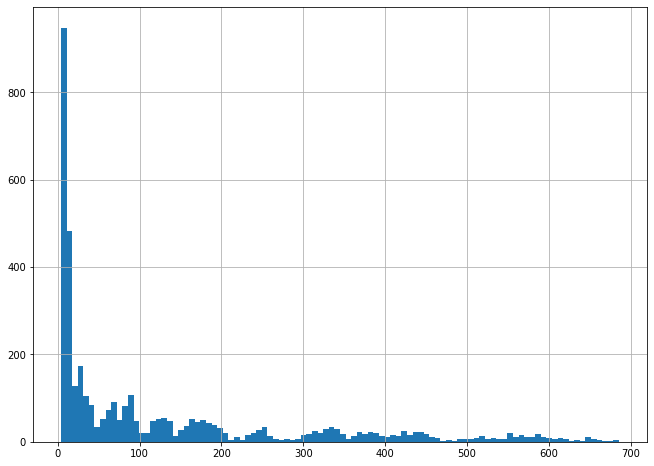

In [60]:
aapl_df.close.hist(figsize=(11, 8), bins=100)

t = ax.title.set_text("Histogram: Closing Prices")


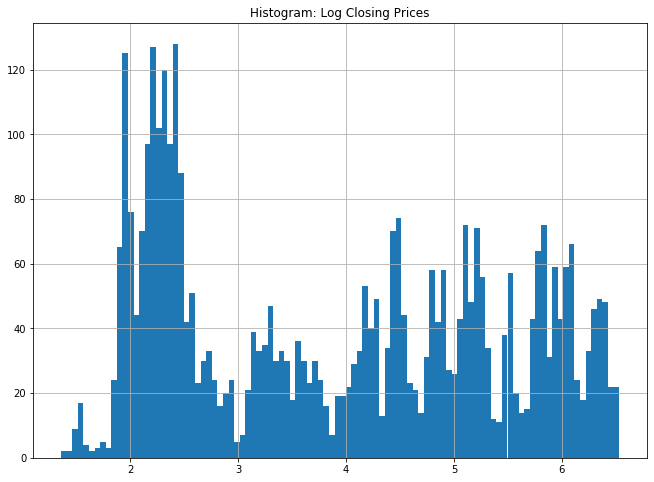

In [61]:
ax = aapl_df.close.apply(np.log).hist(figsize=(11, 8), bins=100)

t = ax.title.set_text("Histogram: Log Closing Prices")

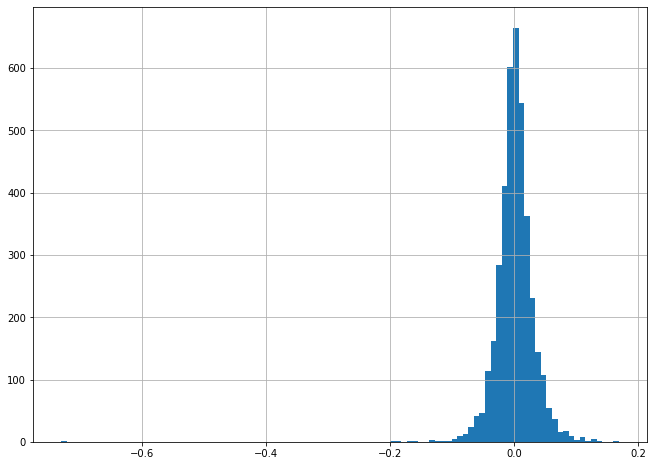

In [62]:
aapl_df.close.apply(np.log).diff().hist(figsize=(11, 8), bins=100)

t = ax.title.set_text("Histogram: Log Returns")

# 2.Predictive Model

## Classical Time Series Models - ARMA 

### Basic / Benchmark Models

In [63]:
train = train.return_daily
test = test.return_daily

#### Average

In [64]:
model = lambda: train.mean()
model()

0.0017979570942215008

In [65]:
y_pred = pd.Series([model() for _ in range(test.shape[0])], index=test.index)

In [66]:
r2_score(test, y_pred)

-0.07597763639405897

In [67]:
y_pred

date
2012-12-03    0.001798
2012-12-04    0.001798
2012-12-05    0.001798
2012-12-06    0.001798
2012-12-07    0.001798
2012-12-10    0.001798
2012-12-11    0.001798
2012-12-12    0.001798
2012-12-13    0.001798
2012-12-14    0.001798
2012-12-17    0.001798
2012-12-18    0.001798
2012-12-19    0.001798
2012-12-20    0.001798
2012-12-21    0.001798
2012-12-24    0.001798
2012-12-26    0.001798
2012-12-27    0.001798
2012-12-28    0.001798
2012-12-31    0.001798
dtype: float64

In [68]:
r2_score(test.iloc[1:], test.shift(1).iloc[1:])

-1.0085314567136514

### Partial Autocorrelation

In [69]:
partial_auto = pd.Series(pacf(aapl_df.return_daily.dropna(), nlags=90))

In [70]:
partial_auto.index.name = "lags"

In [71]:
partial_auto = partial_auto.iloc[1:]

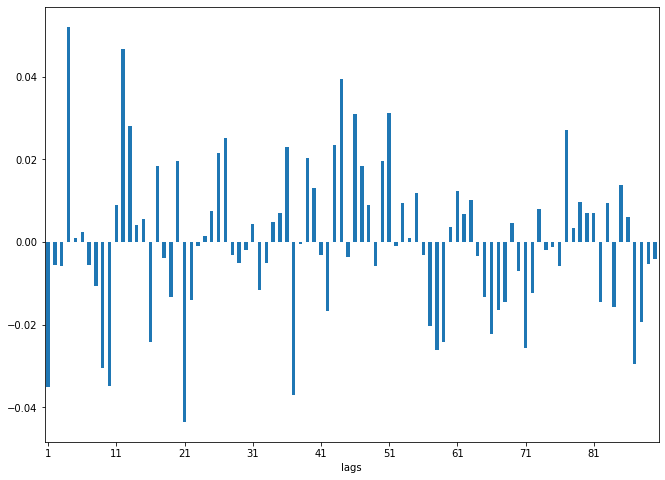

In [72]:
ax = partial_auto.plot.bar(figsize=(11, 8), rot=0)
plt.locator_params(nbins=9)
xlab = ax.set_xticklabels((1, 11, 21, 31, 41, 51, 61, 71, 81, 91))

In [73]:
partial_auto.abs().sort_values(ascending=False)[:10]

lags
4     0.052106
12    0.046723
21    0.043522
44    0.039513
37    0.036973
1     0.034998
10    0.034851
51    0.031274
46    0.030994
9     0.030490
dtype: float64

In [74]:
to_keep = partial_auto.abs().sort_values(ascending=False)[:10].index

In [75]:
to_keep

Int64Index([4, 12, 21, 44, 37, 1, 10, 51, 46, 9], dtype='int64', name='lags')

# Feature Engineering

In [76]:
def get_shifted_feature(srs, shift_num):
    return srs.shift(shift_num)

In [77]:
def get_shifted(srs, shift_nums_list):
    """
    Returns a df, with each column corresponding to `srs` being shifted,
    for each num in `shift_nums_list`.
    """
    return pd.concat([
                        get_shifted_feature(srs, i).rename(f"{srs.name}_shifted_{i}")
                        for i in shift_nums_list
            ], axis=1)

In [78]:
aapl_features = get_shifted(aapl_df.return_daily, to_keep)

In [79]:
aapl_features.shape

(3926, 10)

In [80]:
aapl_features.dropna().head()

,return_daily_shifted_4,return_daily_shifted_12,return_daily_shifted_21,return_daily_shifted_44,return_daily_shifted_37,return_daily_shifted_1,return_daily_shifted_10,return_daily_shifted_51,return_daily_shifted_46,return_daily_shifted_9
date,,,,,,,,,,
1998-03-19,0.011935,0.024746,0.045847,0.005106,-0.006152,0.018954,-0.017961,-0.015384,0.007122,0.013301
1998-03-20,-0.021010,0.056490,-0.001460,-0.025394,-0.006708,-0.007069,0.013301,0.183749,0.065833,-0.071780
1998-03-23,-0.006776,-0.017961,-0.027318,-0.022928,0.000000,-0.011614,-0.071780,-0.079196,0.005106,0.068936
1998-03-24,0.018954,0.013301,0.065699,0.013335,-0.035845,-0.012131,0.068936,0.035552,-0.025394,0.080197
1998-03-25,-0.007069,-0.071780,0.000000,-0.006317,-0.009699,0.072143,0.080197,0.010519,-0.022928,0.026025


In [81]:
aapl_features = aapl_features.join(
                    aapl_df[[
                        "return_mean_21_day",
                        "return_cumulative_21_day",
                        "return_std_21_day"
                    ]].shift(1))

In [82]:
aapl_features.shape

(3926, 13)

In [83]:
train = d_o_w.loc[datetime.date(2011, 1, 1):datetime.date(2012, 11, 30)]
train = train.join(aapl_features, how="left")
test = d_o_w.loc[datetime.date(2012, 12, 1):datetime.date(2012, 12, 31)]
test = test.join(aapl_features, how="left")

train.columns

Index(['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'return_daily', 'return_daily_shifted_4', 'return_daily_shifted_12',
       'return_daily_shifted_21', 'return_daily_shifted_44',
       'return_daily_shifted_37', 'return_daily_shifted_1',
       'return_daily_shifted_10', 'return_daily_shifted_51',
       'return_daily_shifted_46', 'return_daily_shifted_9',
       'return_mean_21_day', 'return_cumulative_21_day', 'return_std_21_day'],
      dtype='object')

In [84]:
X_cols = [c for c in train.columns if c != "return_daily"]

In [85]:
X_train = train.loc[:, X_cols]
y_train = train.loc[:, "return_daily"]
X_test = test.loc[:, X_cols]
y_test = test.loc[:, "return_daily"]

In [86]:
X_train.dtypes.value_counts()

float64    13
uint8       4
dtype: int64

In [87]:
scaler = StandardScaler()

In [88]:
float_cols = X_train.select_dtypes(include=float).columns

In [89]:
X_train.loc[:, float_cols] = scaler.fit_transform(X_train.loc[:, float_cols])

In [90]:
X_train.loc[:, float_cols].mean()

return_daily_shifted_4     -1.888761e-17
return_daily_shifted_12     2.035601e-17
return_daily_shifted_21    -2.142132e-17
return_daily_shifted_44    -3.915724e-18
return_daily_shifted_37    -2.764041e-18
return_daily_shifted_1     -9.213469e-19
return_daily_shifted_10     1.474155e-17
return_daily_shifted_51     1.612357e-18
return_daily_shifted_46     4.606735e-18
return_daily_shifted_9      4.606735e-19
return_mean_21_day          2.441569e-17
return_cumulative_21_day    6.311226e-17
return_std_21_day          -6.910102e-17
dtype: float64

In [91]:
X_train.loc[:, float_cols].std()

return_daily_shifted_4      1.001039
return_daily_shifted_12     1.001039
return_daily_shifted_21     1.001039
return_daily_shifted_44     1.001039
return_daily_shifted_37     1.001039
return_daily_shifted_1      1.001039
return_daily_shifted_10     1.001039
return_daily_shifted_51     1.001039
return_daily_shifted_46     1.001039
return_daily_shifted_9      1.001039
return_mean_21_day          1.001039
return_cumulative_21_day    1.001039
return_std_21_day           1.001039
dtype: float64

In [92]:
X_test.loc[:, float_cols] = scaler.fit_transform(X_test.loc[:, float_cols])


## Linear Regression

In [93]:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)

In [94]:
linreg.score(X_train, y_train)

0.0515292282830323

In [95]:
linreg.score(X_test, y_test)

-0.03480735758584097

## Ridge

In [96]:
ridge = Ridge(alpha=10**3)

In [97]:
ridge = ridge.fit(X_train, y_train)

In [98]:
ridge.score(X_train, y_train)

0.01635202184697826

In [99]:
ridge.score(X_test, y_test)

-0.09215821200480279

## Visualization

In [100]:
y_test_pred = ridge.predict(X_test)

In [101]:
y_test = y_test.rename("y_test").to_frame()

In [102]:
y_test["y_pred"] = y_test_pred

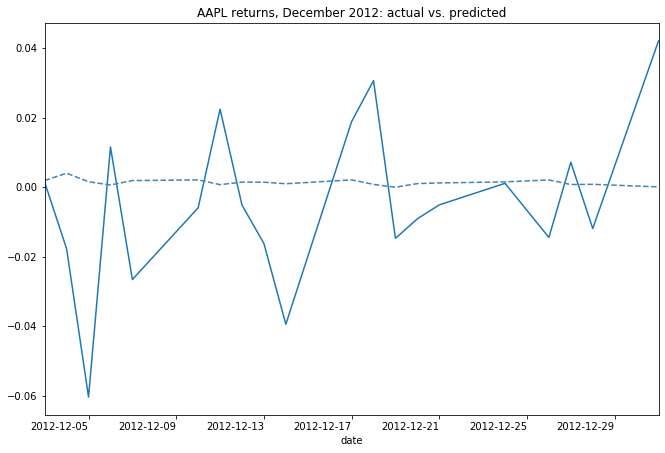

In [103]:
ax = y_test.y_test.plot(figsize=(11, 8), rot=0)
ax = y_test.y_pred.plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, December 2012: actual vs. predicted")

In [104]:
y_test.head()

,y_test,y_pred
date,,
2012-12-03,0.001420,0.001952
2012-12-04,-0.017719,0.004058
2012-12-05,-0.060336,0.001585
2012-12-06,0.011614,0.000664
2012-12-07,-0.026545,0.001924


# 3. Walk-Forward Validation

In [105]:
aapl_features = aapl_features.join(d_o_w.drop("return_daily", axis=1))

In [106]:
def time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials):

    results = []

    for i in range(num_trials):
        end_date = start_date + datetime.timedelta(days=trial_width)
        # we now have a window of [start_date, end_date] to train / test split on

        # get beginning of test window (end is `end_date`)
        test_start = end_date - datetime.timedelta(days=test_width)

        # get end of train window (beginning is `start_date`)
        train_end = test_start -datetime.timedelta(days=1)

        # get `X` and `y` for training
        X_train = X.loc[start_date:train_end, :].copy()
        y_train = y.loc[start_date:train_end]

        # get `X` and `y` for testing 
        X_test = X.loc[test_start:end_date, :].copy()
        y_test = y.loc[test_start:end_date]

        # if passing `test_width` of 1, you may hit weekends, etc. with no trades
        # so want to make sure you have a non-empty test set
        if X_test.shape[0] > 0:
                
            # grab `float` columns and standard scale them
            float_cols = X.select_dtypes(include=float).columns
            X_train.loc[:, float_cols] = scaler.fit_transform(X_train.loc[:, float_cols])
            X_test.loc[:, float_cols] = scaler.fit_transform(X_test.loc[:, float_cols])

            # fit model to training data
            model_obj = model_obj.fit(X_train, y_train)
            
            # make predictions
            y_pred = model_obj.predict(X_test)
            
            # send to `y_test` to frame, so that predictions can be another column in same `DataFrame`
            y_test = y_test.to_frame()
            y_test["y_pred"] = y_pred

            # save trial results
            results.append(y_test)
        
        # slide `start_date` forward
        start_date = start_date + datetime.timedelta(days=test_width +1)
    
    # get concatenation of the `list` into a `DataFrame`
    results = pd.concat(results)

    # add `month` and `year` columns
    results["year"] = results.index.year
    results["month"] = results.index.month
    
    return results

## Run Trial

In [107]:
model_obj = LinearRegression()

In [108]:
X = aapl_features.copy()

In [109]:
X.columns

Index(['return_daily_shifted_4', 'return_daily_shifted_12',
       'return_daily_shifted_21', 'return_daily_shifted_44',
       'return_daily_shifted_37', 'return_daily_shifted_1',
       'return_daily_shifted_10', 'return_daily_shifted_51',
       'return_daily_shifted_46', 'return_daily_shifted_9',
       'return_mean_21_day', 'return_cumulative_21_day', 'return_std_21_day',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4'],
      dtype='object')

In [110]:
y = aapl_df.return_daily

In [111]:
start_date = datetime.date(2009, 1, 2)

In [112]:
trial_width = 365

In [113]:
test_width = 1

In [114]:
num_trials = 100

In [115]:
results = time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials)


In [116]:
results.head()

,return_daily,y_pred,year,month
date,,,,
2010-01-04,0.016518,0.004654,2010,1
2010-01-05,0.000701,0.002136,2010,1
2010-01-06,-0.016521,0.004781,2010,1
2010-01-07,-0.001990,0.001552,2010,1
2010-01-08,0.007175,0.004141,2010,1


In [117]:
results.tail()

,return_daily,y_pred,year,month
date,,,,
2010-07-13,-0.020145,0.010093,2010,7
2010-07-14,0.003293,0.008802,2010,7
2010-07-15,-0.003876,-0.001212,2010,7
2010-07-16,-0.007072,-0.001545,2010,7
2010-07-19,-0.019197,0.005191,2010,7


In [118]:
r2_score(results.return_daily, results.y_pred)

-0.06168107481077523

In [119]:
def get_r2(group):
    return r2_score(group["return_daily"], group["y_pred"])

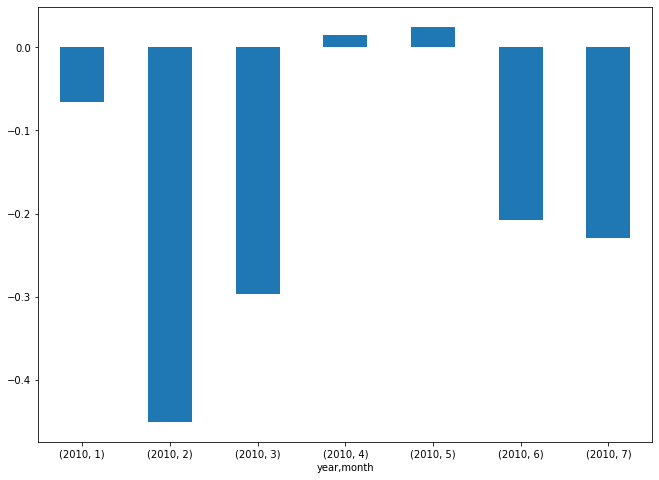

In [120]:
ax = results.groupby(["year", "month"]).apply(get_r2).plot.bar(figsize=(11, 8), rot=0)

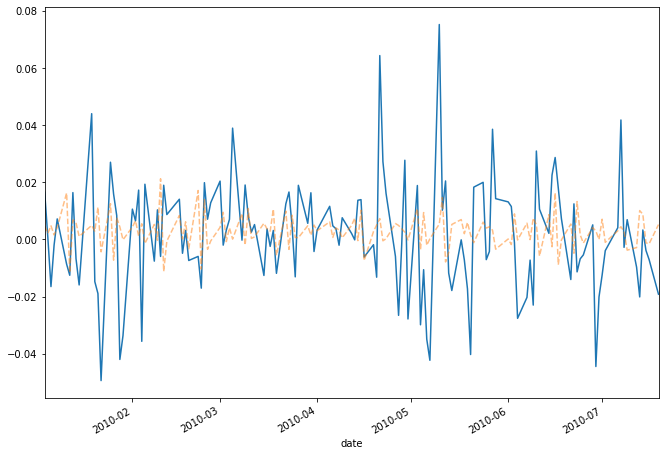

In [121]:
ax = results.return_daily.plot(figsize=(11, 8), rot=0)

ax = results.y_pred.plot(ax=ax, linestyle="--", alpha=.5)

In [122]:
aapl_features.columns

Index(['return_daily_shifted_4', 'return_daily_shifted_12',
       'return_daily_shifted_21', 'return_daily_shifted_44',
       'return_daily_shifted_37', 'return_daily_shifted_1',
       'return_daily_shifted_10', 'return_daily_shifted_51',
       'return_daily_shifted_46', 'return_daily_shifted_9',
       'return_mean_21_day', 'return_cumulative_21_day', 'return_std_21_day',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4'],
      dtype='object')

## Run Trial

In [123]:
model_obj = Ridge(alpha=10**3)

In [124]:
X = aapl_features.copy()

In [125]:
X.columns

Index(['return_daily_shifted_4', 'return_daily_shifted_12',
       'return_daily_shifted_21', 'return_daily_shifted_44',
       'return_daily_shifted_37', 'return_daily_shifted_1',
       'return_daily_shifted_10', 'return_daily_shifted_51',
       'return_daily_shifted_46', 'return_daily_shifted_9',
       'return_mean_21_day', 'return_cumulative_21_day', 'return_std_21_day',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4'],
      dtype='object')

In [126]:
y = aapl_df.return_daily

In [127]:
start_date = datetime.date(2009, 1, 2)

In [128]:
trial_width = 365

In [129]:
test_width = 1

In [130]:
num_trials = 100

In [131]:
results = time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials)

In [132]:
results.head()

,return_daily,y_pred,year,month
date,,,,
2010-01-04,0.016518,0.003593,2010,1
2010-01-05,0.000701,0.003387,2010,1
2010-01-06,-0.016521,0.003572,2010,1
2010-01-07,-0.001990,0.003038,2010,1
2010-01-08,0.007175,0.004073,2010,1


In [133]:
results.tail()

,return_daily,y_pred,year,month
date,,,,
2010-07-13,-0.020145,0.004234,2010,7
2010-07-14,0.003293,0.003153,2010,7
2010-07-15,-0.003876,0.001893,2010,7
2010-07-16,-0.007072,0.002180,2010,7
2010-07-19,-0.019197,0.002180,2010,7


In [134]:
r2_score(results.return_daily, results.y_pred)

-0.0074489090308957895

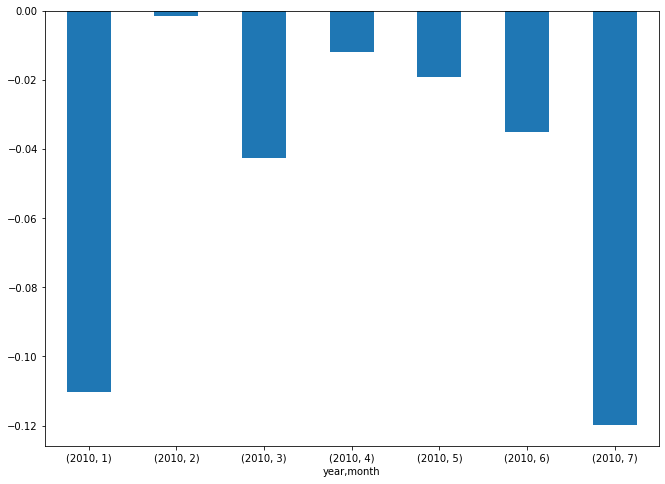

In [135]:
ax = results.groupby(["year", "month"]).apply(get_r2).plot.bar(figsize=(11, 8), rot=0)

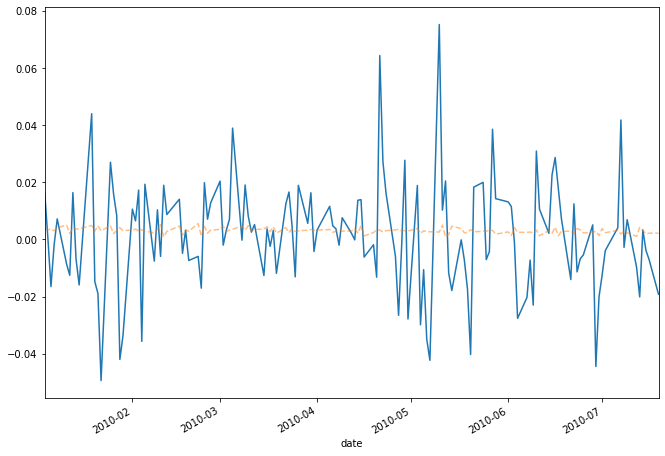

In [136]:
ax = results.return_daily.plot(figsize=(11, 8), rot=0)
ax = results.y_pred.plot(ax=ax, linestyle="--", alpha=.5)

## Run Trial

In [137]:
def get_max_over_last_days(srs, x=5):
    return srs.rolling(x).max()

In [138]:
def get_min_over_last_days(srs, x=5):
    return srs.rolling(x).min()

In [139]:
aapl_features["max_last_5"] = get_max_over_last_days(aapl_df.return_daily).shift(1)

In [140]:
aapl_features["min_last_5"] = get_min_over_last_days(aapl_df.return_daily).shift(1)

In [141]:
aapl_features["return_std_5_day"] = aapl_df.return_daily.rolling(5).std().shift(1)

In [142]:
aapl_features["return_cumulative_5_day"] = (aapl_df.return_daily_gross.rolling(5).apply(np.prod) - 1).shift(1)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [143]:
aapl_features["return_std_10_day"] = aapl_df.return_daily.rolling(10).std().shift(1)

In [144]:
aapl_features["return_cumulative_10_day"] = (aapl_df.return_daily_gross.rolling(10).apply(np.prod) - 1).shift(1)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [145]:
aapl_features.columns.sort_values().tolist()

['day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'max_last_5',
 'min_last_5',
 'return_cumulative_10_day',
 'return_cumulative_21_day',
 'return_cumulative_5_day',
 'return_daily_shifted_1',
 'return_daily_shifted_10',
 'return_daily_shifted_12',
 'return_daily_shifted_21',
 'return_daily_shifted_37',
 'return_daily_shifted_4',
 'return_daily_shifted_44',
 'return_daily_shifted_46',
 'return_daily_shifted_51',
 'return_daily_shifted_9',
 'return_mean_21_day',
 'return_std_10_day',
 'return_std_21_day',
 'return_std_5_day']

In [146]:
X = aapl_features.drop(
            ['return_daily_shifted_12',
             'return_daily_shifted_37',
             'return_daily_shifted_4',
             'return_daily_shifted_44',
             'return_daily_shifted_46',
             'return_daily_shifted_51',
             'return_daily_shifted_9',
             'return_mean_21_day'],
            axis=1)

In [147]:
model_obj = Ridge(alpha=10**3)

In [148]:
y = aapl_df.return_daily

In [149]:
start_date = datetime.date(2009, 1, 2)

In [150]:
trial_width = 365

In [151]:
test_width = 1

In [152]:
num_trials = 100

In [153]:
results = time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials)

In [154]:
results.head()

,return_daily,y_pred,year,month
date,,,,
2010-01-04,0.016518,0.003592,2010,1
2010-01-05,0.000701,0.004019,2010,1
2010-01-06,-0.016521,0.002941,2010,1
2010-01-07,-0.001990,0.003272,2010,1
2010-01-08,0.007175,0.003836,2010,1


In [155]:
results.tail()

,return_daily,y_pred,year,month
date,,,,
2010-07-13,-0.020145,0.003001,2010,7
2010-07-14,0.003293,0.003050,2010,7
2010-07-15,-0.003876,0.001996,2010,7
2010-07-16,-0.007072,0.002186,2010,7
2010-07-19,-0.019197,0.002181,2010,7


In [156]:
r2_score(results.return_daily, results.y_pred)

-0.015399228661585163

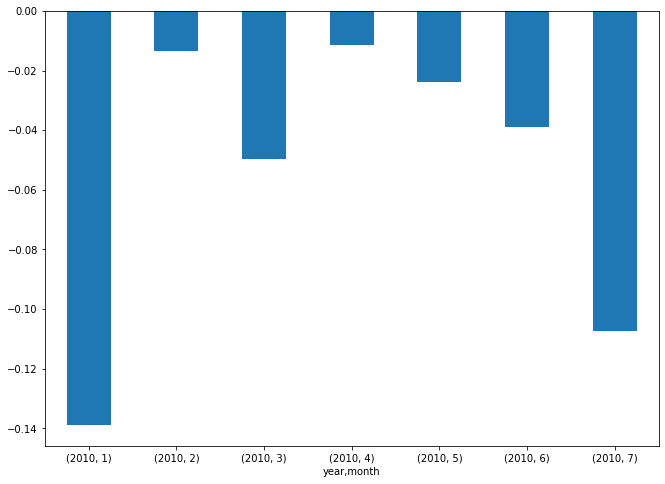

In [157]:
ax = results.groupby(["year", "month"]).apply(get_r2).plot.bar(figsize=(11, 8), rot=0)

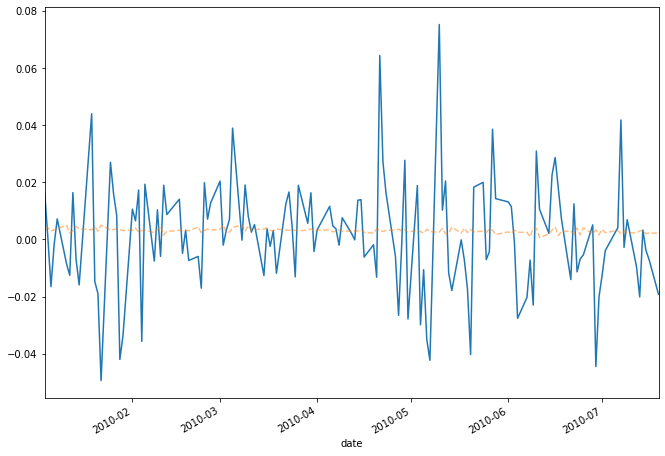

In [158]:
ax = results.return_daily.plot(figsize=(11, 8), rot=0)

ax = results.y_pred.plot(ax=ax, linestyle="--", alpha=.5)

## Run Trial

In [159]:
model_obj = Ridge(alpha=10**3)

In [160]:
start_date = datetime.date(2009, 1, 2)

In [161]:
trial_width = 365

In [162]:
test_width = 1

In [163]:
num_trials = 365

In [164]:
results = time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials)

In [165]:
results.head()

,return_daily,y_pred,year,month
date,,,,
2010-01-04,0.016518,0.003592,2010,1
2010-01-05,0.000701,0.004019,2010,1
2010-01-06,-0.016521,0.002941,2010,1
2010-01-07,-0.001990,0.003272,2010,1
2010-01-08,0.007175,0.003836,2010,1


In [166]:
results.tail()

,return_daily,y_pred,year,month
date,,,,
2011-12-23,0.012421,0.000788,2011,12
2011-12-27,0.007358,0.001231,2011,12
2011-12-28,-0.009890,0.001032,2011,12
2011-12-29,0.006438,0.000817,2011,12
2011-12-30,-0.000300,0.000946,2011,12


In [167]:
r2_score(results.return_daily, results.y_pred)

-0.005388088352573872

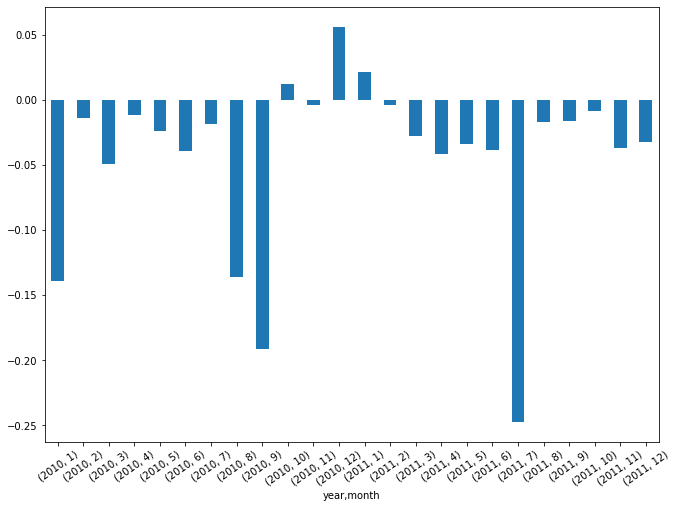

In [168]:
ax = results.groupby(["year", "month"]).apply(get_r2).plot.bar(figsize=(11, 8), rot=35)

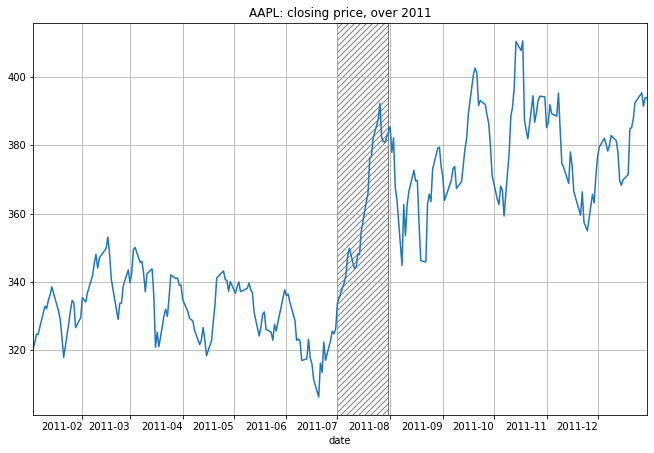

In [169]:
ax = aapl_df.loc[
            datetime.date(2011, 1, 1): datetime.date(2011, 12, 31)
                ].close.plot(figsize=(11, 8), rot=0)

g = ax.grid(True)
t = ax.title.set_text("AAPL: closing price, over 2011")

fill = ax.axvspan(
            datetime.date(2011, 7, 1),
            datetime.date(2011, 7, 31),
            edgecolor="black",
            facecolor="white",
            alpha=.5,
            hatch="////")

## Run Final Trial

In [170]:
aapl_features["month"] = aapl_features.index.month

In [171]:
aapl_features["month"] = aapl_features.index.month

In [172]:
aapl_features["max_last_10"] = get_max_over_last_days(aapl_df.return_daily, 10).shift(1)

In [173]:
aapl_features["max_last_21"] = get_max_over_last_days(aapl_df.return_daily, 21).shift(1)

In [174]:
aapl_features["max_last_63"] = get_max_over_last_days(aapl_df.return_daily, 63).shift(1)

In [175]:
aapl_features["return_cumulative_63_day"] = (aapl_df.return_daily_gross.rolling(63).apply(np.prod) - 1).shift(1)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [176]:
aapl_features["return_std_63_day"] = aapl_df.return_daily.rolling(63).std().shift(1)

In [177]:
model_obj = Ridge(alpha=10**3)

In [178]:
X = aapl_features.copy()

In [179]:
y = aapl_df.return_daily

In [180]:
start_date = datetime.date(2009, 1, 2)

In [181]:
trial_width = 365

In [182]:
test_width = 1

In [183]:
num_trials = 365

In [184]:
results = time_series_validation(model_obj, X, y, start_date, trial_width, test_width, num_trials)

In [185]:
results.head()

,return_daily,y_pred,year,month
date,,,,
2010-01-04,0.016518,0.003846,2010,1
2010-01-05,0.000701,0.003678,2010,1
2010-01-06,-0.016521,0.003807,2010,1
2010-01-07,-0.001990,0.003264,2010,1
2010-01-08,0.007175,0.004248,2010,1


In [186]:
results.tail()

,return_daily,y_pred,year,month
date,,,,
2011-12-23,0.012421,0.000033,2011,12
2011-12-27,0.007358,0.000730,2011,12
2011-12-28,-0.009890,0.000606,2011,12
2011-12-29,0.006438,0.000175,2011,12
2011-12-30,-0.000300,0.000443,2011,12


In [187]:
r2_score(results.return_daily, results.y_pred)

-0.0022348873392146196

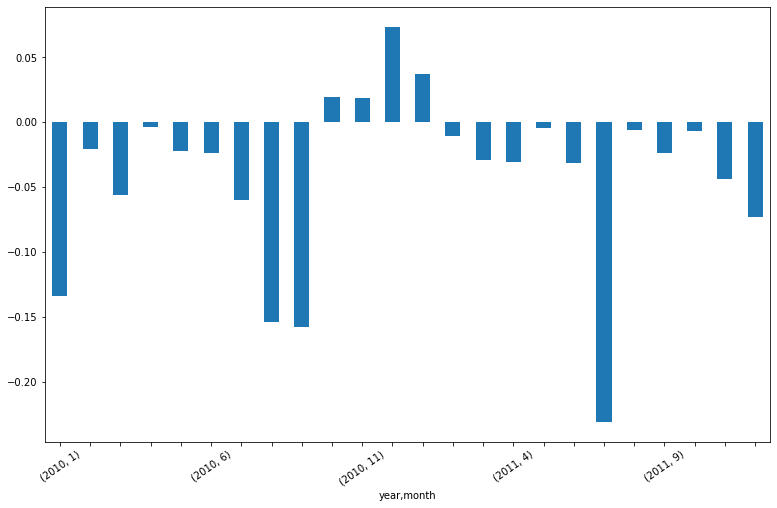

In [188]:
ax = results.groupby(["year", "month"]).apply(get_r2).plot.bar(figsize=(13, 8), rot=35)

# hide certain ticks to make plot more readable
for i, t in enumerate(ax.get_xticklabels()):
    if not i % 5 == 0:
        t.set_visible(False)
